In [1]:
%load_ext rpy2.ipython
import os, subprocess, shutil, sys
import pandas as pd
import numpy as np
import scipy.stats

<a id=top></a>
# Figures for manuscript
## Primary manuscript figures
#### Fig1. [Distributions of RM in Prokaryotes](#fig1)
#### Fig2. [Models and Latin Hypercube Sampling](#fig2)
#### Fig3. [Scaling of RM Systems](#fig3)
#### Fig4. [RM Distribuiton](#fig4)


In [2]:
def mean_confidence_interval(series, confidence=0.95):
    series = 1.0 *series
    n = len(series)
    m, se = series.mean(), series.sem()
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

    

#basic statistics with data
gendat = pd.read_csv('NotebooksAndData/RMsearch/data/generadat.csv')
orgdat = pd.read_csv('NotebooksAndData/RMsearch/data/orgdat.csv')

print("Number of genomes analyzed {}".format(str(len(orgdat))))
print("Mean RM of genomes {} +/- {}".format(str(orgdat['rmTotal'].mean()), 
                                            str(mean_confidence_interval(orgdat['rmTotal']))))
print("95th quantile RM of Genera {} ".format(str(orgdat['rmTotal'].quantile(q=.95))))
print("5th quantile RM of Genera {} ".format(str(orgdat['rmTotal'].quantile(q=.05))))

print("standard deviation {}".format(orgdat['rmTotal'].std()))
print('')
print("Number of Genera analyzed {}".format(str(len(gendat))))
print("Mean RM of Genera {} +/- {}".format(str(gendat['rmTotal'].mean()), 
                                           str(mean_confidence_interval(gendat['rmTotal']))))
print("standard deviation {}".format(gendat['rmTotal'].std()))
print("median RM of Genera {} ".format(str(gendat['rmTotal'].median())))
print("95th quantile RM of Genera {} ".format(str(gendat['rmTotal'].quantile(q=.95))))
print("5th quantile RM of Genera {} ".format(str(gendat['rmTotal'].quantile(q=.05))))
print('')
gendat = gendat[gendat['num_isolates'] >= 5]


print("Mean RM of Genera {} +/- {}".format(str(gendat['rmTotal'].mean()), 
                                           str(mean_confidence_interval(gendat['rmTotal']))))
print("Mean Genome of Genera {} +/- {}".format(str(gendat['bp'].mean()), 
                                           str(mean_confidence_interval(gendat['bp']))))
print("median RM of Genera {} ".format(str(gendat['rmTotal'].median())))
print("95th quantile RM of Genera {} ".format(str(gendat['rmTotal'].quantile(q=.95))))
print("5th quantile RM of Genera {} ".format(str(gendat['rmTotal'].quantile(q=.05))))
print("standard deviation {}".format(gendat['rmTotal'].std()))

Number of genomes analyzed 139023
Mean RM of genomes 1.9380534156218756 +/- 0.010502018454871316
95th quantile RM of Genera 5.0 
5th quantile RM of Genera 0.0 
standard deviation 1.9978562333795653

Number of Genera analyzed 2522
Mean RM of Genera 2.4748185364731414 +/- 0.09419259842793928
standard deviation 2.4123075106268947
median RM of Genera 2.0 
95th quantile RM of Genera 6.0 
5th quantile RM of Genera 0.0 

Mean RM of Genera 2.174860555680387 +/- 0.11868196547916365
Mean Genome of Genera 3934198.509990493 +/- 120182.34236855125
median RM of Genera 1.905525846702317 
95th quantile RM of Genera 4.4 
5th quantile RM of Genera 0.42737500000000006 
standard deviation 1.6798209335188423


<a id=fig1></a>
## Figure 1 - Distributions of RM systems in Prokaryotes
## Distributuion of all prokaryotes
    - 5 or more isolates per data point
    - hexagons rendered when there are 5 or more datapoints
[Top of page](#top)

In [3]:
cyanogen = pd.read_csv('NotebooksAndData/RMsearch/data/cyanodat.csv')
cyanoorg = orgdat[orgdat['phyla'] == 'Cyanobacteria']
g = set(cyanogen[cyanogen['num_isolates'] >=5]['genus'])
g.add("Raphidiopsis")
g.add("Trichodesmium")
g.add("Dolichospermum")

cyanoorg = cyanoorg[cyanoorg['genus'].isin(g)]

[1] 0.1184957
      5% 
0.427375 


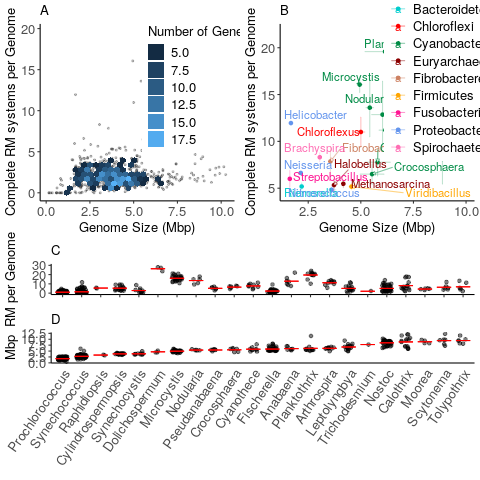

In [24]:
%%R -i cyanoorg
library("ggplot2")
#library("sandwich")
library("hexbin")
library("MASS")
library('ggrepel')#this package is incompatible with windows!
library("pscl")
library("gridExtra")


get_legend<-function(a.gplot){
    tmp <- ggplot_gtable(ggplot_build(a.gplot))
    leg <- which(sapply(tmp$grobs, function(x){x$name}) == "guide-box")
                        legend <- tmp$grobs[[leg]]
  return(legend)}



suppress_hexbin <- function(data, x, y, threshold = 0, bins=30,
                            points_alpha=0.25, point_size=1){
  # pre-summarise the data
  hexinfo <- hexbin(dat[,x], dat[,y], xbins=bins)
  # Extract the _centers_ of the hexagons as the x and y coordinates
  df_hex <- data.frame(hcell2xy(hexinfo), count=hexinfo@count)
  return(
    ggplot(subset(df_hex,count>threshold),aes(x,y,fill=count)) +
      geom_point(data=dat, mapping=aes(dat[,x], dat[,y]),inherit.aes = FALSE, alpha = points_alpha, size = point_size)+
      geom_hex(stat="identity")
  )
}

get_95CI <- function(s,n) {
  return(qnorm(0.975)*s/sqrt(n))
}

dat<-read.csv('NotebooksAndData/RMsearch/data/generadat.csv')
dat$Mbp<-dat$bp/1000000
dat.all <-dat
#RESTRICTING BY GENERA WITH 5 OR MORE ISOLATES
dat<-subset(dat,num_isolates >=5)
rm95 = quantile(dat$rmTotal, .95)
mbp95 = quantile(dat$Mbp, .95)
#adding data elements to caption, title
len = nrow(dat)
meanrm = mean(dat$rmTotal)
CIrm = print(get_95CI(sd(dat$rmTotal),length(dat$rmTotal)))

medianrm = median(dat$rmTotal)
#assigning points for either binhex or geompoint
dat_points=subset(dat,rmTotal > rm95 | Mbp > mbp95 )
dat_bin=subset(dat,rmTotal <= rm95 & Mbp <= mbp95 )


ylab="Complete RM systems per Genome"
xlab="Genome Size (Mbp)"
axis_text_size=13

A <- suppress_hexbin(data = dat, x='Mbp',y='rmTotal', threshold = 4, point_size=.75 )+
  labs(y=ylab,x = xlab,
       title='A')+
  theme_bw() + 
  theme(panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"), 
        legend.position=c(.825,.65),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size),
        legend.text=element_text(size=axis_text_size),
        legend.title=element_text(size=axis_text_size))+
  guides(fill=guide_legend(title="Number of Genera"))


################# 95% PLOTS ################################

custom_colorscale<-scale_colour_manual(values = c("Chloroflexi" = "red",
                                                  "Cyanobacteria" = "springgreen4",
                                                  "Euryarchaeota"="red4",
                                                  "Fibrobacteres" = "lightsalmon3",
                                                  "Proteobacteria"="cornflowerblue",
                                                  "Spirochaetes"="hotpink1",
                                                  "Actinobacteria"="gold4",
                                                  "Bacteroidetes"="cyan3",
                                                  "Chlamydiae"="plum4",
                                                  "Crenarchaeota"="grey0",
                                                  "Firmicutes"="orange1",
                                                  "Fusobacteria" = "deeppink"))

dat$RMCI <-get_95CI(dat$rmTotal_std,dat$num_isolates)
dat$MbpCI <-get_95CI(dat$bp_std,dat$num_isolates)/1000000

RM95 = quantile(dat$rmTotal, .95)
dat.RM95 <- dat[dat['rmTotal'] >= RM95,] #restriction above line
dat.RM95 <- dat.RM95[dat.RM95['rmTotal']-dat.RM95['RMCI'] >= RM95,] #restriction to CI that is not below RM95.pT2G

print(quantile(dat$rmTotal, .05))

B<-ggplot(data = dat.RM95, aes(x=Mbp,y=rmTotal, color=phyla, label=genus) )+
  geom_point()+
  geom_errorbar(aes(ymin=rmTotal-RMCI,ymax=rmTotal+RMCI),alpha=.25)+
  geom_errorbarh(aes(xmin=Mbp-MbpCI,xmax=Mbp+MbpCI),alpha=.25)+
  labs(y=ylab,
       x = xlab,title='B')+
  theme_bw() + 
  theme(panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        legend.position=c(.84,.75),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size),
        legend.text=element_text(size=axis_text_size),
        legend.title=element_text(size=axis_text_size))+
  guides(color=guide_legend(title="Phylum"))+custom_colorscale

B<- B+ geom_text_repel(size=4,max.iter=5000,segment.alpha=.5,
                               arrow = grid::arrow(length = unit(0.05, "inches"),
                                                   type="closed"))

##################CYANOBACTERIA########      

cyano.org<-read.csv('NotebooksAndData/RMsearch/data/cyanodat.csv')
cyano.org$Mbp<-cyano.org$bp/1000000
cyano.org.iso5 <- subset(cyano.org,num_isolates >= 5 | 
                         genus == "Raphidiopsis" | 
                         genus == "Trichodesmium"|
                         genus == "Dolichospermum")

cyano.org.iso5$genus<- factor(cyano.org.iso5$genus, 
                              levels = unique(cyano.org.iso5$genus[order(cyano.org.iso5$bp)]))

cyanoorg$Mbp<- cyanoorg$bp/1000000
cyanoorg$rmperMbp <-cyanoorg$rmTotal/cyanoorg$Mbp
cyanoorg$genus<- factor(cyanoorg$genus, 
                        levels = unique(cyano.org.iso5$genus[order(cyano.org.iso5$bp)]))

C<- ggplot(cyanoorg,aes(y=rmTotal,x=genus))+
  #geom_boxplot()+
  geom_jitter(alpha = 0.5,width = 0.25)+ 
  stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
                 width = .75, color = 'red')+
  labs(y="RM per Genome",x = element_blank(),
       title='C')+
  theme_bw() + 
  theme(axis.text.x = element_blank(),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size))+
  ylim(c(0,30))

D<- ggplot(cyanoorg,aes(y=Mbp,x=genus))+
  geom_jitter(alpha = 0.5,width = 0.25)+ 
  stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
                 width = .75, color = 'red')+
  labs(y="Mbp",x = element_blank(),title='D')+
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 55, hjust = 1),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),axis.ticks.x=element_blank(),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size))#+
  #ylim(c(0,12))
gC<-ggplotGrob(C)
gD <- ggplotGrob(D)
CD <- rbind(gC,gD)

#CD<-grid.arrange(C,D, ncol=1,heights=c(3.5,1.5))


plt<-grid.arrange(
    A,B,CD,
    nrow=2,
    layout_matrix = rbind(c(1,2),
                         c(3,3))
)
ggsave('figures/Figure1.png',plot=plt,width=12,height=10,device='png',dpi=900)


In [9]:
%%R

install.packages("ggrepel", repos='http://cran.us.r-project.org')

R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/ggrepel_0.8.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 538532 bytes (525 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

In [59]:
%%R

lmp <- function (modelobject) {
  if (class(modelobject) != "lm") stop("Not an object of class 'lm' ")
  f <- summary(modelobject)$fstatistic
  p <- pf(f[1],f[2],f[3],lower.tail=F)
  attributes(p) <- NULL
  return(p)
}

print_eq<- function(df){
    m = lm( rmTotal ~ Mbp, df);
    eq <- substitute(italic(y) == a + b %.% italic(x), 
         list(a = format(coef(m)[1], digits = 2), 
              b = format(coef(m)[2], digits = 2)
             ))
    as.character(as.expression(eq));                 
}

print_Pval = function(df){
  m = lm(rmTotal ~ Mbp, df);
  eq <- substitute(~~italic(p)~"="~pval, 
                   list(
                        pval = format(lmp(m),digits = 8)
                        )
                   
                   )
  as.character(as.expression(eq));    
}

print_Rsqrd = function(df){
  m = lm( rmTotal ~ Mbp, df);
  eq <- substitute(~~R^2~"="~r2, 
                   list(
                       r2 = format(summary(m)$r.squared, digits = 3)
                        )
                   
                   )
  as.character(as.expression(eq));                 
}

RM05 = quantile(dat$rmTotal, .05)
dat.RM05 <- dat[dat['rmTotal'] <= RM05,] #restriction above line
dat.RM05 <- dat.RM05[dat.RM05['rmTotal']+dat.RM05['RMCI'] <= RM05,] #restriction to CI that is not below RM95.pT2G
dat.RM05 <- dat.RM05[!grepl("Candidatus", dat.RM05$genus),]


###############statistics##########
sink('Figure1_statistics.txt')
#getting stats on lm
print("mean RM")
print(meanrm)
print("CI RM")
print(CIrm)
print("95Quantile")
print(RM95)
print("05Quantile")
print(RM05)
print("LM statistics:")
pval = print_Pval(dat)
r2 = print_Rsqrd(dat)
eq = print_eq(dat)
print(r2)
print(eq)
print(pval)

print(summary(lm(rmTotal~Mbp,data=dat)))

model.nb<-glm.nb(rmTotal ~ Mbp, data = dat)
print(summary(model.nb))

print(with(model.nb, cbind(res.deviance = deviance, df = df.residual,
  p = pchisq(deviance, df.residual, lower.tail=FALSE))))

print(pR2(model.nb))

print("####################################################################")                      
#the following is alternate code for doing a goodness of fit test
print(with(model.nb, cbind(res.deviance = deviance, df = df.residual,
  p = pchisq(summary(model.nb)$deviance, summary(model.nb)$df.residual, lower.tail=FALSE))))

#McFadden pseudo R squared
print(1-logLik(model.nb)/logLik(glm.nb(rmTotal ~ 1, data = dat)))       


sink()                   
                      
                      

newdata2 <- data.frame(
  Mbp = rep(seq(from = min(dat$rmTotal), to = max(dat$rmTotal), length.out = 100), 3))

newdata2 <- cbind(newdata2, predict(model.nb, newdata2, type = "link", se.fit=TRUE))
newdata2 <- within(newdata2, {
  rmTotal <- exp(fit)
  LL <- exp(fit - 1.96 * se.fit)
  UL <- exp(fit + 1.96 * se.fit)
})

                      #THIS IS TO ADD A REGRESSION LINE TO NEGATIVE BINOMIAL MODEL
#print(
#ggplot(newdata2, aes(Mbp, rmTotal))+
#  geom_ribbon(aes(ymin = LL, ymax = UL), alpha = .25) +
#  geom_line(size = 2) +
#  labs(x = "Mbp", y = "rmTotal")+
#  xlim(0,10)
#)


Statististical model outputs from above
plt1
    linear model: p = 0.00181*, R2 = 0.0138
     *All this is saying is that the slope is non-zero
    neg binomial: McFadden Pseudo R2 is 4.11e-3, Mbp estimate = 0.04713

In [18]:
alpha=gen[gen['rep'] == 284].iloc[0]['alpha']
beta=gen[gen['rep'] == 284].iloc[0]['beta']
c=gen[gen['rep'] == 284].iloc[0]['c']
r=gen[gen['rep'] == 284].iloc[0]['r']
phi=gen[gen['rep'] == 284].iloc[0]['phi']

for i,row in gen[gen['Sr'] > 10**8].iterrows():
    if row['c'] >.4 and row['c'] <.6 and row['phi'] < 5e-8 and row['phi']> 5e-7 and row['pr'] > .7:
        print(row)

In [20]:
gen['phi'].min()

1.0024833884361896e-08

In [13]:
rep =230
dict(gen[gen['rep']== rep].iloc[0][['alpha','beta','c','r','phi','delta_p','delta_c','pr']])

{'alpha': 1.17910244620957,
 'beta': 38.0,
 'c': 0.4114284683723774,
 'r': 3.5730832726962396e-05,
 'phi': 9.164759429210716e-07,
 'delta_p': 0.2783278326650398,
 'delta_c': 0.2345059590267404,
 'pr': 0.8528506365549331}

<a id=fig2></a>
# Figure 2: Latin Hypercube Sampling
![cartton](figures/Models.png)
[Top of page](#top)

In [43]:
dfmem=pd.read_csv("NotebooksAndData/GenMemODE/data/2member_Memory_endpoints.csv")
dfgen=pd.read_csv("NotebooksAndData/GenMemODE/data/2member_General_endpoints.csv")
dfpar=pd.read_csv("NotebooksAndData/GenMemODE/data/2member_Parallel_endpoints.csv")
dfpar.replace({"Population":"Phage"},"Competition Phage",inplace=True)


def process_LHS(results):
    #We must provide a floor for our data to .1 so we can visualize in logspace.
    #our floor will be 1 (not inclusive) and we will fix these datapoints at an abundance of .1
    Dtemp=[]
    Ctemp=[]
    results['Sr']=results['Sr'].round()
    for el in results['Defense Specialist']:
        if el <1:
            Dtemp.append(1)
        else:
            Dtemp.append(el)
    for el in results['Competition Specialist']:
        if el <1:
            Ctemp.append(1)
        else:
            Ctemp.append(el)
    results['Defense Specialist']=Dtemp
    results['Competition Specialist']=Ctemp
    S_rng = set(results['Sr'])
    m=[]
    qh=.75
    ql=.25
    for S in S_rng:
        df = results[results['Sr'] == S][['Competition Specialist','Defense Specialist']]
        rep_num=len(df)
        t=list(pd.concat([df.mean(),df.median(),df.std(),df.quantile(qh),df.quantile(ql)]))
        t.append(rep_num)
        t.append(S)
        m.append(t)
    df = pd.DataFrame(m)
    #building column names for stats of each treatment
    stats=['mean','median','std','qh','ql','rep_num',"Sr"]
    col=[]
    for stat in stats[:-2]:
        col.append('C'+stat)
        col.append('D'+stat)
    col.extend(stats[-2:])
    df.columns=col
    results['ratio'] = results['Defense Specialist']/results['Competition Specialist']
    ratio = results[['Sr','rep','ratio']]

    #Here, we are sampling 100 points in logspace so we can make bins
    bins = np.logspace(np.log10(ratio['Sr'].min()),np.log10(ratio['Sr'].max()),50)
    #finding the interval each S belongs to
    ratio['bin'] = pd.cut(ratio['Sr'], bins)
    #Describing the bin as the midpoint of the interval for ploting
    ratio = ratio.dropna()
    ratio['bin_Sr'] = [intS.mid for intS in ratio['bin']]
    ratio= ratio[['Sr','ratio','bin_Sr']]
    return(df,ratio)

gen=pd.read_csv('NotebooksAndData/GenMemODE/data/LHS/general.csv')
df_gen,ratio_gen = process_LHS(gen)

par=pd.read_csv('NotebooksAndData/GenMemODE/data/LHS/Parallel.csv')
df_par,ratio_par = process_LHS(par)

mem=pd.read_csv('NotebooksAndData/GenMemODE/data/LHS/Memory.csv')
df_mem,ratio_mem = process_LHS(mem)

/home/spiro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
set(dfpar['Population'])

{'Competition Phage',
 'Competition Specialist',
 'Defense Phage',
 'Defense Specialist'}

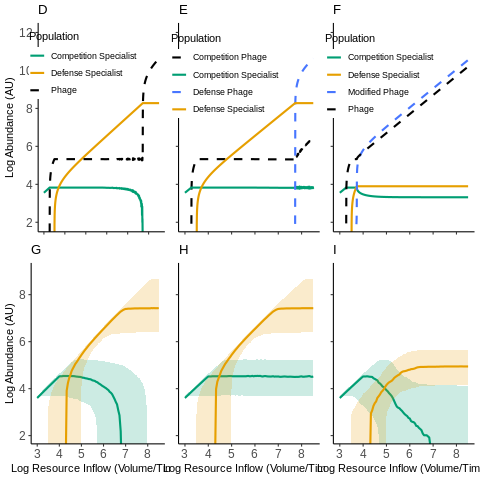

In [46]:
%%R -i df_gen,df_par,df_mem,dfmem,dfgen,dfpar
library("ggplot2")
library("gridExtra")


custom_colorscale<-scale_colour_manual(values = c("b1" = "#009E73", "Competition Specialist"="#009E73",
                                                  "b2" = "#E69F00","Defense Specialist"="#E69F00",
                                                 "p"="#000000","General Phage"="#000000","Competition Phage"="#000000",
                                                  "Phage"="#000000","p1"="#000000",
                                                 "p2"="royalblue1","Modified Phage"="royalblue1",
                                                 "Defense Phage"="royalblue1"))

custom_linetype<-scale_linetype_manual(values = c("b1" = "solid", "Competition Specialist"="solid",
                                                  "b2" = "solid","Defense Specialist"="solid",
                                                 "p"="dashed","General Phage"="dashed",
                                                  "Phage"="dashed","p1"="dashed",
                                                 "p2"="dashed","Modified Phage"="dashed",
                                                 "Defense Phage"='dashed',"Competition Phage"='dashed'))


g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) {x$name}) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}

axis_text_size=12
sim_lim=200                      
ylowerlim = 10^2
yupperlim=10^12 
yupperlim_LHS=10^9
lsize=1


ModVar<-function(df){ggplot(df,aes(x=Sr,y=Cmedian))+
  geom_ribbon(aes(ymin = Cql, ymax = Cqh),alpha=.2, fill = "#009E73")+
  geom_line(aes(color="c"),alpha=1,size=lsize)+
  geom_ribbon(aes(ymin = Dql, ymax = Dqh),alpha=.2, fill = "#E69F00")+
  geom_line(aes(y=Dmedian,color="d"),alpha=1,size=lsize)+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),axis.text.x = element_text(size=axis_text_size),
       axis.text.y = element_text(size=axis_text_size),legend.background=element_blank())+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_colour_manual(guide = 'legend',name = 'Population', 
         values=c('c'='#009E73','d'='#E69F00'), 
         labels = c('Competition Specialist','Defense Specialist'))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim_LHS))
}

plt_simpleVC<-function(df){
    
  plt<-ggplot(df,aes(x=Sr,y=value,color=Population))+
  geom_line(aes(linetype=Population),size=lsize)+custom_linetype+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)")+
  theme(panel.border = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
        axis.text.x = element_text(size=axis_text_size),
       axis.text.y = element_text(size=axis_text_size),
       legend.background=element_blank())+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
  custom_colorscale
    
  return(plt)
}
      
RatVar<-function(ratio){ggplot(ratio, aes(x=bin_Sr, y=ratio,group=bin_Sr))+
  geom_boxplot(notch=FALSE, fill="red",outlier.size=.5,outlier.alpha=.1, alpha=0.2)+#,outlier.shape=NA,)+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  geom_hline(yintercept=1, size=1.5,linetype="dashed", color = "black")+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Def/Comp")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),axis.text.x = element_text(size=axis_text_size),
       axis.text.y = element_text(size=axis_text_size))}


D<-plt_simpleVC(dfgen)+labs(title="D")+theme(legend.position = c(0.35, 0.8))+
    theme(axis.title.x=element_blank(),axis.text.x=element_blank())
E<-plt_simpleVC(dfpar)+labs(title="E")+theme(legend.position = c(0.325, 0.75))+
    theme(axis.title=element_blank(),axis.text=element_blank())
F<-plt_simpleVC(dfmem)+labs(title="F")+theme(legend.position = c(0.325, 0.75))+
    theme(axis.title=element_blank(),axis.text=element_blank())

G<-ModVar(df_gen)+guides(color=FALSE)+labs(title="G")
    

H<-ModVar(df_par)+labs(title="H")+guides(color=FALSE)+
    theme(axis.title.y=element_blank(),axis.text.y=element_blank())

I<-ModVar(df_mem)+labs(title="I")+guides(color=FALSE)+#theme(legend.position = c(0.40, 0.80))+
    theme(axis.title.y=element_blank(),axis.text.y=element_blank())

gridplt<-grid.arrange(D,E,F,
                      G,H,I,
                      nrow = 2,widths=c(1.1,1,1))

ggsave("figures/Model_Variance.png",plot=gridplt,width=8,height=6,device="png",dpi=1200)


In [27]:
gen_Sr = gen[gen['Sr'] == gen['Sr'].max()]
par_Sr = par[par['Sr'] == par['Sr'].max()]
mem_Sr = mem[mem['Sr'] == mem['Sr'].max()]
print(mem['Sr'].max())
print(len(gen_Sr))

316227766.0
990


In [22]:
%%R -i gen_Sr,par_Sr,mem_Sr
library(car)

gmod <-lm(Defense.Specialist ~ alpha+beta+c+r+phi+delta_p+delta_c,data=gen_Sr)
print(Anova(gmod))

pmod <-lm(Defense.Specialist ~ alpha+beta+c+r+phi+delta_p+delta_c,data=par_Sr)
print(Anova(pmod))

mmod <-lm(Defense.Specialist ~ alpha+beta+c+r+phi+delta_p+delta_c+pr,data=mem_Sr)
print(Anova(mmod))


Anova Table (Type II tests)

Response: Defense.Specialist
              Sum Sq  Df F value    Pr(>F)    
alpha     5.2682e+18   1  1.6508 0.1991556    
beta      3.4284e+18   1  1.0743 0.3002322    
c         8.2208e+16   1  0.0258 0.8725210    
r         3.5199e+19   1 11.0297 0.0009297 ***
phi       2.3231e+19   1  7.2794 0.0070945 ** 
delta_p   1.9630e+19   1  6.1511 0.0132997 *  
delta_c   1.1774e+18   1  0.3689 0.5437313    
Residuals 3.1339e+21 982                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Anova Table (Type II tests)

Response: Defense.Specialist
              Sum Sq  Df  F value    Pr(>F)    
alpha     6.9110e+17   1   3.1184  0.077722 .  
beta      7.4327e+18   1  33.5380 9.402e-09 ***
c         1.7828e+14   1   0.0008  0.977379    
r         2.9906e+19   1 134.9411 < 2.2e-16 ***
phi       3.0815e+19   1 139.0439 < 2.2e-16 ***
delta_p   1.4845e+18   1   6.6986  0.009792 ** 
delta_c   6.0008e+17   1   2.7077  0.100183    
Residuals 

<a id=fig3></a>
# Figure 3: Scaling of RM Systems
[Top of page](#top)

In [7]:
def R_prep(df,extra=[]):
    dfR=get_ProducerColumns(df,extra)
    idvars=['Sr']+extra
    dfR = pd.melt(dfR,id_vars=idvars)
    dfR.columns = idvars+["NumRM","value"]
    dfR['NumRM'] = [ int(el.split('_')[-1]) for el in dfR['NumRM'] ]
    return(dfR)


def get_ProducerColumns(df,extra=[]):
    _=['Sr']+extra
    for member in list(df.columns):
        if 'P_' in member:
            _.append(member)
    df = df[_]
    return(df)

#This must be identical to partial_resistance.py
i_pr = {i:pr for i,pr in enumerate(np.around(np.arange(start=0.0,stop=1.05,step=.05),4))}
dfs=[]
#The following be used to generate panel C
path ='NotebooksAndData/GenMemODE/data/partial_r/orgRM_stacking/'
for file in os.listdir(path):
    if '.csv' in file:
        df = pd.read_csv(path+file,index_col=False)
        i = int(file.split('_')[-1].split('.')[0])
        if i_pr[i] == .5:
            dfmem=R_prep(df)
#The following be used to generate the different memory lines in panel D
path ='NotebooksAndData/GenMemODE/data/partial_r/orgRM_unique/'
for file in os.listdir(path):
    if '.csv' in file:
        df = pd.read_csv(path+file,index_col=False)
        i = int(file.split('_')[-1].split('.')[0])
        if i_pr[i] in [.9,.5,.1]:
            df['Model'] = "Memory, m={}".format(str(i_pr[i]))
            dfs.append(df)
            
            
# Because final abundance of Memory ~= Parallel, we will consolidate
# to ploting only the general model instead of Parallel and General
df = pd.read_csv("NotebooksAndData/GenMemODE/data/10member_General_endpoints.csv",
                 index_col=False)
df['Model'] = "General, Parallel"
totals_min = float(df[df['Sr'] < df[df['P_1'] > 1e4]['Sr'].min()].iloc[-1]['Sr'])-1
dfs.append(df)

#df = pd.read_csv("data/10member_Parallel_endpoints.csv",index_col=False)
#df['Model'] = "Parallel"
#dfs.append(df)
        
df = pd.concat(dfs)

df = get_ProducerColumns(df,['Model'])
df['total_abundance'] = df[df.columns[2:]].sum(axis=1)
df['HighestRM'] = df[df.columns[2:-1]].idxmax(axis=1)
df['HighestRM'] = [int(el.split('_')[-1]) for el in df['HighestRM']]
df_totals = df[['Sr','Model','total_abundance','HighestRM']]
df_totals = df_totals[df_totals['Sr'] >= totals_min]
df=pd.read_csv("NotebooksAndData/GenMemODE/data/10member_Parallel_endpoints.csv")
dfpar=R_prep(df)
#dfpar = dfpar[dfpar['NumRM'] <4]

df=pd.read_csv("NotebooksAndData/GenMemODE/data/10member_General_endpoints.csv")
dfgen=R_prep(df)
#dfgen = dfgen[dfgen['NumRM'] <4]


/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [8]:
%%R -i dfgen,dfpar,dfmem,df_totals
library("ggplot2")
library("gridExtra")


ylowerlim = 10^4
yupperlim=10^10
lsize=1
axis_text_size=12
axis_label_size=15
legend_textsize = 12
yname = "Log Abundance (AU)"
xname = "Log Resource Inflow (Volume/Time)"


df_totals$Model <-as.factor(df_totals$Model)

set_breaks <- function(limits) {
    if ((limits[2] - limits[1]) < 5){
        x=seq(limits[1], limits[2], by = 1) 
    }
    else{
        x=seq(limits[1], limits[2], by = 3)
    }
    return(x)
}
plt_ComplexVC<-function(df){
  plt<-ggplot(df,aes(x=Sr,y=value,group=NumRM,color=NumRM))+
  geom_line(size=lsize)+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)",
       color="Population \nRM number")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
        axis.text = element_text(size=axis_text_size),
        axis.title= element_text(size=axis_label_size),
        legend.position = c(.15,.75),
        legend.text=element_text(size=legend_textsize),
        legend.title=element_text(size=legend_textsize))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
    #scale_colour_gradient(low = '#009E73',high = "#E69F00",breaks = set_breaks)
    #alternate = #E69F00 gold
    # lighter gold #ffb61a
    #alternate = #fae100 yellow
    #alternate green =#009c2e
    scale_colour_gradient2(low = "#009E73",mid = "#E69F00",
                         high = "#fae100",breaks = set_breaks,midpoint=4)
  return(plt)
}


A<-plt_ComplexVC(dfgen)
B<-plt_ComplexVC(dfpar)+labs(x="Log Resource Inflow (Volume/Time)")+theme(axis.text.y=element_blank(),
                                                                          axis.title.y=element_blank())
C<-plt_ComplexVC(dfmem)


D<-ggplot(df_totals,aes(x=HighestRM,y=total_abundance,group=Model,color=Model))+
  geom_line()+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  theme_bw()+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),axis.text.y=element_blank(),
        panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
        axis.text = element_text(size=axis_text_size),
        axis.title= element_text(size=axis_label_size),
        legend.position = c(.65,.2),
        legend.text=element_text(size=legend_textsize),
        legend.title=element_text(size=legend_textsize))+
  labs(x="Number of RM in Dominate Population",y=" ")+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
  scale_x_continuous(limits=c(0,9),breaks=c(0,1,2,3,4,5,6,7,8,9) )
  
#gridplt<-grid.arrange(A+labs(title='A'),
#                      B+labs(title='B'),
#                      C+labs(title='C'),
#                      D+labs(title='D')+theme(axis.text.y=element_blank(),
#                                                axis.axis.y=element_blank()),
#                      nrow = 2)

gA <- ggplotGrob(A+labs(title='A'))
gB <- ggplotGrob(B+labs(title='B'))
gC <- ggplotGrob(C+labs(title='C'))
gD <- ggplotGrob(D+labs(title='D'))
final <- rbind(cbind(gA, gB),cbind(gC, gD))
ggsave('figures/Abundance_RMnum.png',plot=final,width=9,height=9,device='png',dpi=900)


R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



<a id=fig4></a>
# Figure 4: RM Distribution
[Top of page](#top)

In [9]:
i_pr = {i:pr for i,pr in enumerate(np.around(np.arange(start=0.0,stop=1.05,step=.05),4))}
dfs=[]
paths =['NotebooksAndData/GenMemODE/data/partial_r/orgRM_unique/',
        'NotebooksAndData/GenMemODE/data/partial_r/orgRM_mixed/',
        'NotebooksAndData/GenMemODE/data/partial_r/orgRM_stacking/']
for path in paths:
    for file in os.listdir(path):
        if '.csv' in file:
            RMtype = path.split('_')[-1][:-1]
            df = pd.read_csv(path+file,index_col=False)
            i = int(file.split('_')[-1].split('.')[0])
            if i_pr[i] in [.5]:
                print(i_pr[i])
                dfs.append(df)
                            
#df=pd.concat(dfs)
u_5,m_5,s_5=[R_prep(df) for df in dfs]

#For Graphing puposes, we are removing orgs because they never enter in certian simulations
#u_1 = u_1[u_1['NumRM'] < 7]
#s_1 = s_1[s_1['NumRM'] < 7]

0.5
0.5
0.5


In [10]:
%%R -i u_5,s_5

ylowerlim = 10^5
yupperlim=10^9
lsize=1
axis_text_size=12
axis_label_size=15
legend_textsize = 12
yname = "Log Abundance (AU)"
xname = "Log Resource Inflow (Volume/Time)"


df_totals$Model <-as.factor(df_totals$Model)

set_breaks <- function(limits) {
    if ((limits[2] - limits[1]) < 5){
        x=seq(limits[1], limits[2], by = 1) 
    }
    else{
        x=seq(limits[1], limits[2], by = 3)
    }
    return(x)
}
plt_ComplexVC<-function(df){
  plt<-ggplot(df,aes(x=Sr,y=value,group=NumRM,color=NumRM))+
  geom_line(size=lsize)+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)",
       color="Population \nRM number")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
        axis.text = element_text(size=axis_text_size),
        axis.title= element_text(size=axis_label_size),
        legend.position = c(.15,.75),
        legend.text=element_text(size=legend_textsize),
        legend.title=element_text(size=legend_textsize))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
    #scale_colour_gradient(low = '#009E73',high = "#E69F00",breaks = set_breaks)
    #alternate = #E69F00 gold
    # lighter gold #ffb61a
    #alternate = #fae100 yellow
    #alternate green =#009c2e
    scale_colour_gradient2(low = "#009E73",mid = "#E69F00",
                         high = "#fae100",breaks = set_breaks,midpoint=4)
  return(plt)
}


A<-plt_ComplexVC(s_5)
B<-plt_ComplexVC(u_5)+theme(axis.text.y=element_blank(),axis.title.y=element_blank())

#This excludes mixed
#gridplt<-grid.arrange(A+labs(title='A'),B+labs(title='B'),
#                      nrow = 1)
gA <- ggplotGrob(A+labs(title='A'))
gB <- ggplotGrob(B+labs(title='B'))
gridplt<-cbind(gA, gB)
#gridplt<-grid.arrange(A+labs(title='A'),B+labs(title='B'),C+labs(title='C'),
#                      D+labs(title='D'),E+labs(title='E'),F+labs(title='F'),
#                      G+labs(title='G'),H+labs(title='H'),I+labs(title='I'),
#                      nrow = 3)

ggsave('figures/RMarrangement.png',plot=gridplt,width=9,height=4.5,device='png',dpi=900)

